In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [68]:
df_events = pd.read_csv('sfmc_csv/subscriber_events.csv')

In [57]:
df_events

,SubscriberKey,Event,Domain,Timestamp,JobID
0,aaron02@example.org,unsub,example.org,2024-04-25 00:20:48.898632,442411
1,aaron30@example.org,click,example.org,2024-04-28 10:08:46.575807,355427
2,aaron30@example.org,unsub,example.org,2024-04-28 10:08:46.575807,964505
3,aaron85@example.org,open,example.org,2024-04-10 17:35:42.060171,701968
4,aaron85@example.org,unsub,example.org,2024-04-10 17:35:42.060171,217868
...,...,...,...,...,...
4009,zwise@example.net,sent,example.net,2024-04-09 19:00:34.543371,795586
4010,zwise@example.net,click,example.net,2024-04-09 19:02:56.543371,334812
4011,zwise@example.net,open,example.net,2024-04-09 19:56:56.543371,577041
4012,zwise@example.net,open,example.net,2024-04-09 20:25:56.543371,217868


In [69]:
df_events['Timestamp'] = pd.to_datetime(df_events['Timestamp'])

# Group by campaign_id and event_type, then count the number of events
aggregated_df = df_events.groupby(['JobID', 'Event']).size().reset_index(name='count')

# Pivot the dataframe to have event types as columns
pivot_df = aggregated_df.pivot(index='JobID', columns='Event', values='count').reset_index()

# Rename columns to make it more readable
pivot_df = pivot_df.rename(columns={
    'click': 'clicks',
    'sent': 'sends',
    'open': 'opens',
    'unsub': 'unsubscribes'
})

In [79]:

first_send_dates = df_events[df_events['Event'] == 'sent'].groupby('JobID')['Timestamp'].min().reset_index()

first_send_dates = first_send_dates.rename(columns={'Timestamp': 'FirstSendDate'})

final_df = pd.merge(pivot_df, first_send_dates, on='JobID', how='left')

# Calculate the rolling 7-day average for 'clicks', 'sends', and 'unsubscribes'

# Ensure there are no NaN values in counts
final_df = final_df.fillna(0)

# Convert 'FirstSendDate' to datetime format and set it as the index
final_df['FirstSendDate'] = pd.to_datetime(final_df['FirstSendDate'])
final_df = final_df.set_index('FirstSendDate')

# Sort the DataFrame by the index (FirstSendDate)
final_df = final_df.sort_index()
# Calculate the rolling 7-day average for 'clicks', 'sends', and 'unsubscribes'
rolling_df = final_df[['clicks', 'sends', 'unsubscribes']].rolling(window='7D').mean()

# Concatenate 'JobID' column to the rolling_df
rolling_df['JobID'] = final_df['JobID']

# Reorder columns for better readability
rolling_df = rolling_df[['JobID', 'clicks', 'sends', 'unsubscribes']]

# Display the final DataFrame with rolling averages and JobID
print(rolling_df)

                             JobID     clicks      sends  unsubscribes
FirstSendDate                                                         
2024-04-01 00:03:14.288397  769322  58.000000  56.000000     54.000000
2024-04-01 01:02:00.690477  795586  52.500000  52.000000     46.000000
2024-04-01 01:22:10.039801  785129  51.666667  48.666667     45.666667
2024-04-01 01:37:12.556168  217868  49.500000  49.750000     47.750000
2024-04-01 02:41:58.634487  577041  48.400000  50.000000     46.200000
2024-04-01 02:55:20.207145  964505  50.000000  48.833333     49.333333
2024-04-01 03:55:35.355185  412782  50.000000  49.571429     49.857143
2024-04-01 04:49:41.019917  943918  49.375000  50.750000     50.500000
2024-04-01 04:52:48.218123  730458  48.000000  50.555556     50.666667
2024-04-01 07:10:16.194822  243237  47.000000  51.400000     51.400000
2024-04-01 09:21:28.584129  855010  47.727273  51.727273     50.272727
2024-04-01 09:50:35.648352  411052  48.500000  51.833333     50.583333
2024-0

In [52]:
# Define weights for each event type
event_weights = {'sent': 1, 'open': 2, 'click': 3}

# Function to determine the event with the highest weight preceding the "unsub" event
def analyze_preceding_event(subscriber_events):
    max_weight = 0
    preceding_event = None
    
    for index, row in subscriber_events.iterrows():
        event_type = row['Event']
        weight = event_weights.get(event_type, 0)
        
        if weight > max_weight:
            max_weight = weight
            preceding_event = event_type
            
    return preceding_event, max_weight

# Dictionary to store the contributing event, its weight, last touch, and last touch timestamp for each subscriber
subscriber_touches = {}

# Iterate through DataFrame and organize events for each subscriber
for index, row in df_events.iterrows():
    subscriber = row['SubscriberKey']
    event_type = row['Event']
    timestamp = row['Timestamp']
    
    if subscriber not in subscriber_touches:
        subscriber_touches[subscriber] = {'ContributingEvent': None, 'ContributingEventWeight': None, 'LastTouch': None, 'LastTouchTimestamp': None}
    
    if event_type == 'unsub' and subscriber_touches[subscriber]['ContributingEvent'] is None:
        events_before_unsub = df_events[(df_events['SubscriberKey'] == subscriber) & (df_events['Timestamp'] <= timestamp)]
        preceding_event, weight = analyze_preceding_event(events_before_unsub)
        subscriber_touches[subscriber]['ContributingEvent'] = preceding_event
        subscriber_touches[subscriber]['ContributingEventWeight'] = weight
        
        # Find the last touch event and timestamp
        last_touch_event = events_before_unsub.iloc[0]['Event']
        last_touch_timestamp = events_before_unsub.iloc[0]['Timestamp']
        subscriber_touches[subscriber]['LastTouch'] = last_touch_event
        subscriber_touches[subscriber]['LastTouchTimestamp'] = last_touch_timestamp

# Convert dictionary to DataFrame for better visualization
subscriber_touches_df = pd.DataFrame.from_dict(subscriber_touches, orient='index')

print("Subscriber-level report on events contributing to 'unsub' event:")
print(subscriber_touches_df)


Subscriber-level report on events contributing to 'unsub' event:
                           ContributingEvent  ContributingEventWeight  \
aaron02@example.org                     None                        0   
aaron30@example.org                    click                        3   
aaron85@example.org                     open                        2   
aaronpatterson@example.net             click                        3   
abigail96@example.net                  click                        3   
...                                      ...                      ...   
zraymond@example.com                   click                        3   
zsmith@example.com                      sent                        1   
zwallace@example.org                    open                        2   
zwilliamson@example.net                 None                        0   
zwise@example.net                      click                        3   

                           LastTouch          LastTouchTim

In [53]:
subscriber_touches_df.to_csv('/users/bo/Downloads/result.csv')

In [54]:
# Convert timestamp column to datetime format
df_events['Timestamp'] = pd.to_datetime(df_events['Timestamp'])

# Calculate time differences between consecutive events for each subscriber
df_events['time_diff'] = df_events.groupby('SubscriberKey')['Timestamp'].diff().fillna(pd.Timedelta(seconds=0))

df_events['time_diff_seconds'] = (df_events['time_diff'] / pd.Timedelta(seconds=1)).astype('int')

df_events['hour'] = df_events['Timestamp'].dt.hour
df_events['day_of_week'] = df_events['Timestamp'].dt.dayofweek  # Monday=0, Sunday=6


In [55]:


# Convert categorical variables into numerical values using one-hot encoding
data = pd.get_dummies(df_events, columns=['Event', 'Domain'])

# Define features and target variable
features = data.drop(['SubscriberKey', 'Timestamp','Event_unsub','time_diff'], axis=1)  # Exclude 'subscriberkey' and 'timestamp' from features
target = data['Event_unsub']  # Assuming 'event_type_open' is the target variable


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the testing set
predictions = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       583
        True       1.00      1.00      1.00       220

    accuracy                           1.00       803
   macro avg       1.00      1.00      1.00       803
weighted avg       1.00      1.00      1.00       803



In [199]:
features

,no_sends_within_month,JobID,day_of_week,Event_click,Event_open,Event_sent
0,214,442411,3,False,False,False
1,210,355427,6,True,False,False
2,221,964505,6,False,False,False
3,218,701968,2,False,True,False
4,199,217868,2,False,False,False
...,...,...,...,...,...,...
4009,187,795586,1,False,False,True
4010,162,334812,1,True,False,False
4011,177,577041,1,False,True,False
4012,199,217868,1,False,True,False


In [200]:
import numpy as np
# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], feature_names[indices[f]]))


Feature ranking:
1. feature 1 (0.357228): JobID


IndexError: index 6 is out of bounds for axis 0 with size 6

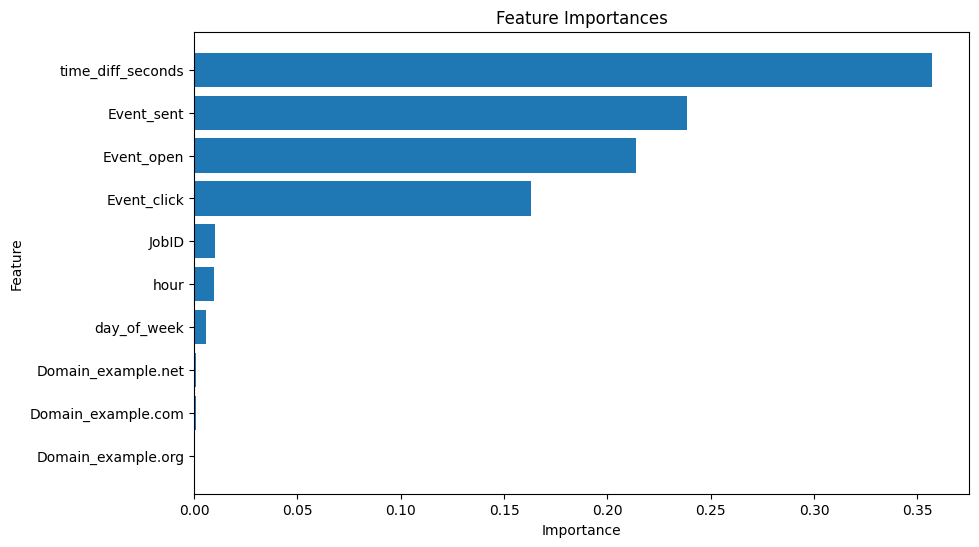

In [196]:

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


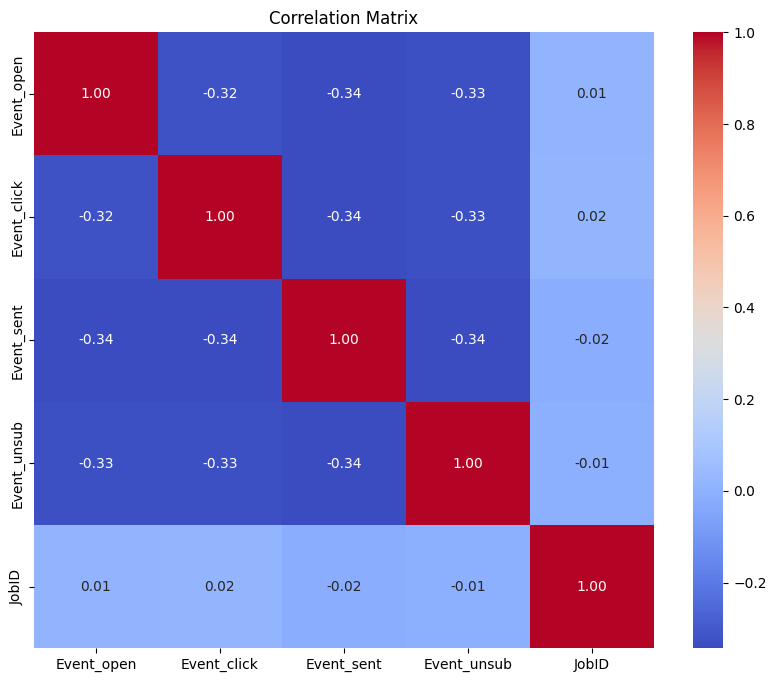

In [58]:
correlation_matrix = data[['Event_open', 'Event_click', 'Event_sent','Event_unsub','JobID']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [76]:

# Filter data to include only unsubscribe events
unsub_data = data[data['Event_unsub'] == 1]

# Initialize lists to store optimal times and number of sends
optimal_times_hr = []
optimal_times_day = []
num_sends_list = []

# Group by subscriber and analyze sending patterns
for subscriber, subgroup in unsub_data.groupby('SubscriberKey'):
    # Sort events by timestamp
    subgroup = subgroup.sort_values(by='Timestamp')
    
    # Determine optimal sent time
    optimal_sent_hr = subgroup['hour'].mode().iloc[0]
    optimal_sent_day = subgroup['day_of_week'].mode().iloc[0]
    optimal_times_hr.append(optimal_sent_hr)
    optimal_times_day.append(optimal_sent_day)
    
    # Count number of sends before unsubscribing
    num_sends = len(subgroup)
    num_sends_list.append(num_sends)

# Calculate average optimal time and average number of sends
average_optimal_hr = pd.Series(optimal_times_hr).mean()
average_optimal_day = pd.Series(optimal_times_day).mean()
average_num_sends = pd.Series(num_sends_list).mean()

print(f"Average Hr: {round(average_optimal_hr)}")
print(f"Average Day: {round(average_optimal_day)}")
print(f"Average Number of Sends Before Unsubscribe: {round(average_num_sends)}")

Average Hr: 11
Average Day: 3
Average Number of Sends Before Unsubscribe: 1


In [101]:
# Filter data to include only the relevant columns (subscriberKey, event_type_sent, event_type_open, event_type_click)
filtered_data = data[['SubscriberKey', 'Event_sent', 'Event_open', 'Event_click','JobID']]

# Group by subscriberKey and sum the event counts
event_counts = filtered_data.groupby(['SubscriberKey','JobID']).sum().reset_index()


In [102]:


# Calculate average number of each event type before unsubscribing
average_sent = event_counts['Event_sent'].mean()
average_open = event_counts['Event_open'].mean()
average_click = event_counts['Event_click'].mean()

print(f"Average number of Sent events before Unsubscribe: {round(average_sent)}")
print(f"Average number of Open events before Unsubscribe: {round(average_open)}")
print(f"Average number of Click events before Unsubscribe: {round(average_click)}")


Average number of Sent events before Unsubscribe: 0
Average number of Open events before Unsubscribe: 0
Average number of Click events before Unsubscribe: 0


In [106]:
event_counts_per_job = filtered_data.groupby('JobID').sum()

# Calculate the average number of Sent events before Unsubscribe
average_sent = event_counts_per_job['Event_sent'].mean()

# Calculate the average number of Open events before Unsubscribe
average_open = event_counts_per_job['Event_open'].mean()

# Calculate the average number of Click events before Unsubscribe
average_click = event_counts_per_job['Event_click'].mean()

print(f"Average number of Sent events before Unsubscribe: {round(average_sent)}")
print(f"Average number of Open events before Unsubscribe: {round(average_open)}")
print(f"Average number of Click events before Unsubscribe: {round(average_click)}")


Average number of Sent events before Unsubscribe: 53
Average number of Open events before Unsubscribe: 49
Average number of Click events before Unsubscribe: 49


In [137]:
# Group by send_id and calculate the number of sends within a month
send_data = data.groupby('JobID').agg({'Timestamp': 'count'}).reset_index()
send_data.rename(columns={'Timestamp': 'no_sends_within_month'}, inplace=True)


In [138]:
unsub_data = data[data['Event_unsub'] == 1]
unsub_counts = unsub_data.groupby('JobID').size().reset_index(name='number_of_unsubscribes')
send_data = pd.merge(send_data, unsub_counts, on='JobID', how='left')
send_data['number_of_unsubscribes'].fillna(0, inplace=True)  # Fill missing values with 0 if there are no unsubscribes for a send_id


/var/folders/x6/bynsqbrs5lj68zq_w2fcwzxr0000gn/T/ipykernel_14507/3326091219.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  send_data['number_of_unsubscribes'].fillna(0, inplace=True)  # Fill missing values with 0 if there are no unsubscribes for a send_id


In [139]:
merged_data = pd.merge(data, send_data, on='JobID', how='inner')

In [164]:


# Define features and label
features = merged_data[['no_sends_within_month','JobID','day_of_week','Event_click','Event_open', 'Event_sent']]
label = merged_data['number_of_unsubscribes']


In [194]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions
predictions = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Assuming rf_regressor is your trained RandomForestRegressor model
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(rf_regressor, f)



Mean Squared Error: 0.0


In [192]:
prediction_df = pd.DataFrame({'JobID': X_test['JobID'], 'no_sends_within_month': X_test['no_sends_within_month'], 'Predicted_number_of_unsubscribes': predictions})

print(prediction_df)

       JobID  no_sends_within_month  Predicted_number_of_unsubscribes
3879  943918                    208                              55.0
2319  855010                    203                              39.0
2717  412782                    207                              53.0
1288  411052                    219                              54.0
3143  577041                    177                              40.0
...      ...                    ...                               ...
2102  436466                    182                              46.0
1006  334812                    162                              35.0
3797  217868                    199                              54.0
2098  735189                    212                              49.0
3455  334812                    162                              35.0

[803 rows x 3 columns]


In [193]:


def predict_unsubscribes(number_of_sends, JobID, day_of_week, Event_sent, Event_open, Event_click):
    # Load your trained model

    with open("trained_model.pkl", "rb") as f:
        rf_regressor = pickle.load(f)
        features = merged_data[['no_sends_within_month','JobID','day_of_week','Event_click','Event_open', 'Event_sent']]

    # Preprocess the input data
    input_data = pd.DataFrame({'no_sends_within_month': [number_of_sends], 'JobID': [JobID]
                                ,'day_of_week':[day_of_week], 'Event_click':[Event_click]
                               ,'Event_open':[Event_open], 'Event_sent':[Event_sent] })

    # Make prediction
    prediction = rf_regressor.predict(input_data)

    return prediction

# Define command-line arguments as variables
number_of_sends = int(input("Enter the number of sends within a month: "))
Event_click = bool(input("Enter the event click: "))
Event_open = bool(input("Enter the event open: "))
Event_sent = bool(input("Enter the event sent: "))
day_of_week =  int(input("Enter the day of week: "))
JobID = int(input("Enter the send ID: "))

# Call the predict_unsubscribes function with provided inputs
prediction = predict_unsubscribes(number_of_sends, JobID, day_of_week, Event_sent, Event_open, Event_click)

print("Predicted number of unsubscribes:", prediction)


ValueError: invalid literal for int() with base 10: ''